In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.api_handler import fetch_spacex_launches, fetch_spacex_launchpads
from src.cleaning import extract_payload_info, clean_success_column, merge_launchpads, extract_payload_mass

df_launches = fetch_spacex_launches()
df_launchpads = fetch_spacex_launchpads()

df_launches.to_csv("../data/launches_raw.csv")
df_launches.head()

,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,rocket.boosters,rocket.cost_per_launch,rocket.success_rate_pct,rocket.first_flight,rocket.country,rocket.company,rocket.wikipedia,rocket.description,rocket.id,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,0,6700000,40,2006-03-24,Republic of the Marshall Islands,SpaceX,https://en.wikipedia.org/wiki/Falcon_1,The Falcon 1 was an expendable launch system p...,5e9d0d95eda69955f709d1eb,NaN
1,None,NaN,False,0.0,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,0,6700000,40,2006-03-24,Republic of the Marshall Islands,SpaceX,https://en.wikipedia.org/wiki/Falcon_1,The Falcon 1 was an expendable launch system p...,5e9d0d95eda69955f709d1eb,NaN
2,None,NaN,False,0.0,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,0,6700000,40,2006-03-24,Republic of the Marshall Islands,SpaceX,https://en.wikipedia.org/wiki/Falcon_1,The Falcon 1 was an expendable launch system p...,5e9d0d95eda69955f709d1eb,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,True,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,0,6700000,40,2006-03-24,Republic of the Marshall Islands,SpaceX,https://en.wikipedia.org/wiki/Falcon_1,The Falcon 1 was an expendable launch system p...,5e9d0d95eda69955f709d1eb,NaN
4,None,NaN,False,0.0,True,[],None,[],[],[],...,0,6700000,40,2006-03-24,Republic of the Marshall Islands,SpaceX,https://en.wikipedia.org/wiki/Falcon_1,The Falcon 1 was an expendable launch system p...,5e9d0d95eda69955f709d1eb,NaN


In [2]:
df_launchpads.to_csv("../data/launchpads_raw.csv")
df_launchpads.head()

,id,name,region
0,5e9e4501f5090910d4566f83,VAFB SLC 3W,California
1,5e9e4501f509094ba4566f84,CCSFS SLC 40,Florida
2,5e9e4502f5090927f8566f85,STLS,Texas
3,5e9e4502f5090995de566f86,Kwajalein Atoll,Marshall Islands
4,5e9e4502f509092b78566f87,VAFB SLC 4E,California


In [3]:
# Create a merged, cleaned version of the datasets
df_merged = merge_launchpads(df_launches, df_launchpads)
df = extract_payload_info(df_merged)
df = clean_success_column(df)

# Rename columns
df.rename(columns={'name_x': 'name', 'name_y': 'site_name'}, inplace=True)

# Save cleaned version
df.to_csv("../data/launches_launchpads_cleaned.csv")

# Preview cleaned data
df[['name', 'rocket.name', 'date_utc', 'success', 'payload_types', 'orbits', 'site_name', 'region']].head()

,name,rocket.name,date_utc,success,payload_types,orbits,site_name,region
0,FalconSat,Falcon 1,2006-03-24T22:30:00.000Z,False,Satellite,LEO,Kwajalein Atoll,Marshall Islands
1,DemoSat,Falcon 1,2007-03-21T01:10:00.000Z,False,Satellite,LEO,Kwajalein Atoll,Marshall Islands
2,Trailblazer,Falcon 1,2008-08-03T03:34:00.000Z,False,"Satellite, Satellite","LEO, LEO",Kwajalein Atoll,Marshall Islands
3,RatSat,Falcon 1,2008-09-28T23:15:00.000Z,True,Satellite,LEO,Kwajalein Atoll,Marshall Islands
4,RazakSat,Falcon 1,2009-07-13T03:35:00.000Z,True,Satellite,LEO,Kwajalein Atoll,Marshall Islands


In [4]:
# Also create a copy where the 'success' column doesn't contain NaN values, for accuracy purposes of the plots
df_clean = df[df['success'].notna()].copy()

In [5]:
# Simplify orbit types: pick the most common or group rare ones as 'Other'
orbit_counts = df_clean['orbits'].value_counts()
common_orbits = orbit_counts[orbit_counts > 10].index.tolist()

df_clean['orbit_category'] = df_clean['orbits'].apply(lambda x: x if x in common_orbits else 'Other')

# Simplify payload types similarly
payload_counts = df_clean['payload_types'].value_counts()
common_payloads = payload_counts[payload_counts > 10].index.tolist()

df_clean['payload_category'] = df_clean['payload_types'].apply(lambda x: x if x in common_payloads else 'Other')

# Show distribution summary
print(df_clean['orbit_category'].value_counts())
print(df_clean['payload_category'].value_counts())
print(df_clean['success'].value_counts())

orbit_category
VLEO     53
GTO      32
ISS      32
Other    27
LEO      18
PO       13
SSO      11
Name: count, dtype: int64
payload_category
Satellite     137
Other          31
Dragon 1.1     18
Name: count, dtype: int64
success
True     181
False      5
Name: count, dtype: int64


In [6]:
orbit_success_ct = pd.crosstab(df_clean['orbit_category'], df_clean['success'])
orbit_success_ct

success,False,True
orbit_category,,
GTO,1,31
ISS,1,31
LEO,2,16
Other,1,26
PO,0,13
SSO,0,11
VLEO,0,53


In [7]:
payload_success_ct = pd.crosstab(df_clean['payload_category'], df_clean['success'])
payload_success_ct

success,False,True
payload_category,,
Dragon 1.1,1,17
Other,1,30
Satellite,3,134


In [8]:
from scipy.stats import chi2_contingency

chi2_orbit, p_orbit, dof_orbit, expected_orbit = chi2_contingency(orbit_success_ct)
chi2_payload, p_payload, dof_payload, expected_payload = chi2_contingency(payload_success_ct)

print(f'Orbit vs Success: p-value = {p_orbit}')
print(f'Payload vs Success: p-value = {p_payload}')

Orbit vs Success: p-value = 0.3061277845781733
Payload vs Success: p-value = 0.6941659968250897


---

## Hypotheses

### Hypothesis 1: Orbit Type and Launch Success

- **Null Hypothesis (H₀):** Launch success is independent of orbit type.
- **Alternative Hypothesis (H₁):** Launch success depends on orbit type.

### Hypothesis 2: Payload Type and Launch Success

- **Null Hypothesis (H₀):** Launch success is independent of payload type.
- **Alternative Hypothesis (H₁):** Launch success depends on payload type.

In [9]:
from IPython.display import Markdown, display

def print_results(chi2_orbit, dof_orbit, p_orbit, chi2_payload, dof_payload, p_payload):
    text = f"""
## Results of Chi-Squared Tests

| Hypothesis                     | Chi-Squared Statistic | Degrees of Freedom | p-value  |
|-------------------------------|-----------------------|--------------------|----------|
| Orbit Type vs Launch Success   | {chi2_orbit:.2f}       | {dof_orbit}         | {p_orbit:.4f} |
| Payload Type vs Launch Success | {chi2_payload:.2f}      | {dof_payload}        | {p_payload:.4f} |

---

## Conclusions

- For **Hypothesis 1 (Orbit Type vs Launch Success)**, the p-value was {p_orbit}.
  - {"Reject the null hypothesis: significant relationship." if p_orbit < 0.05 else "Fail to reject the null hypothesis: no significant relationship."}

- For **Hypothesis 2 (Payload Type vs Launch Success)**, the p-value was {p_payload}.
  - {"Reject the null hypothesis: significant relationship." if p_payload < 0.05 else "Fail to reject the null hypothesis: no significant relationship."}
    """
    display(Markdown(text))

# Then call it with your test results:
print_results(chi2_orbit, dof_orbit, p_orbit, chi2_payload, dof_payload, p_payload)


## Results of Chi-Squared Tests

| Hypothesis                     | Chi-Squared Statistic | Degrees of Freedom | p-value  |
|-------------------------------|-----------------------|--------------------|----------|
| Orbit Type vs Launch Success   | 7.16       | 6         | 0.3061 |
| Payload Type vs Launch Success | 0.73      | 2        | 0.6942 |

---

## Conclusions

- For **Hypothesis 1 (Orbit Type vs Launch Success)**, the p-value was 0.3061277845781733.
  - Fail to reject the null hypothesis: no significant relationship.

- For **Hypothesis 2 (Payload Type vs Launch Success)**, the p-value was 0.6941659968250897.
  - Fail to reject the null hypothesis: no significant relationship.
    

---

# Plots

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# For clean plots
sns.set_theme(style="whitegrid")

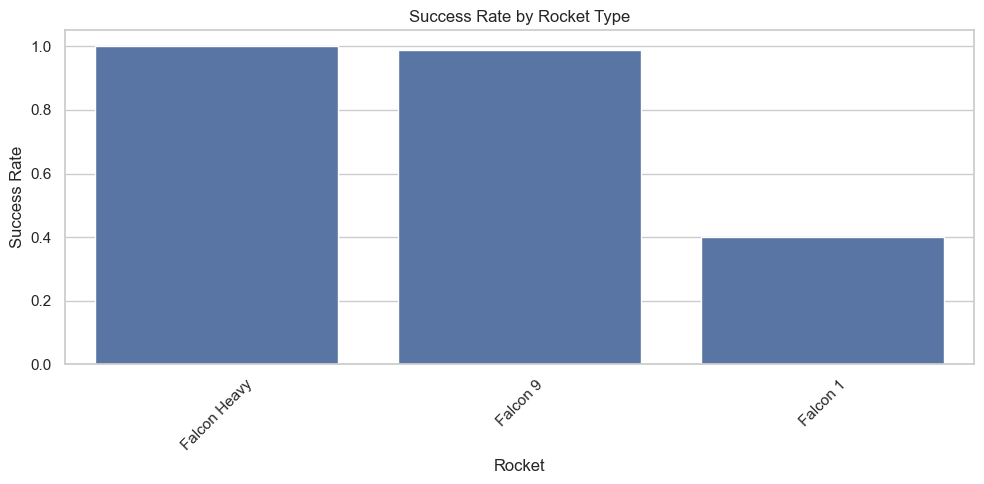

In [11]:
success_by_rocket = df_clean.groupby("rocket.name")["success"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=success_by_rocket.index, y=success_by_rocket.values)
plt.title("Success Rate by Rocket Type")
plt.ylabel("Success Rate")
plt.xlabel("Rocket")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

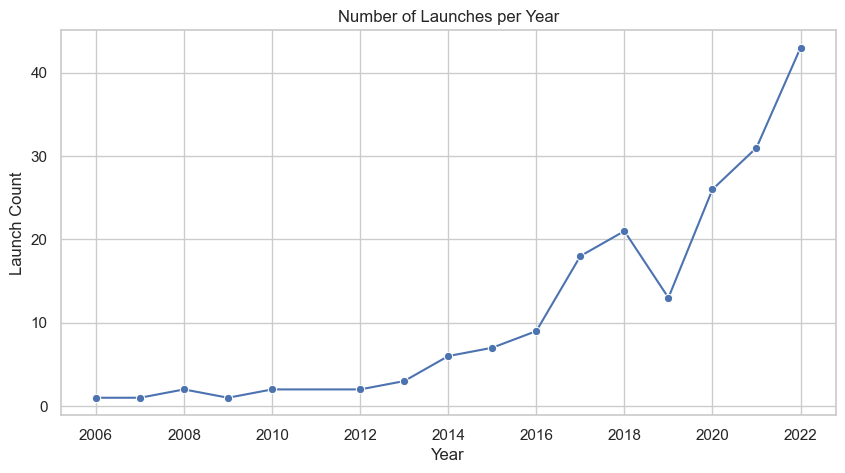

In [12]:
df_clean["year"] = pd.to_datetime(df_clean["date_utc"]).dt.year
launches_per_year = df_clean.groupby("year").size()

plt.figure(figsize=(10, 5))
sns.lineplot(x=launches_per_year.index, y=launches_per_year.values, marker="o")
plt.title("Number of Launches per Year")
plt.xlabel("Year")
plt.ylabel("Launch Count")
plt.grid(True)
plt.show()

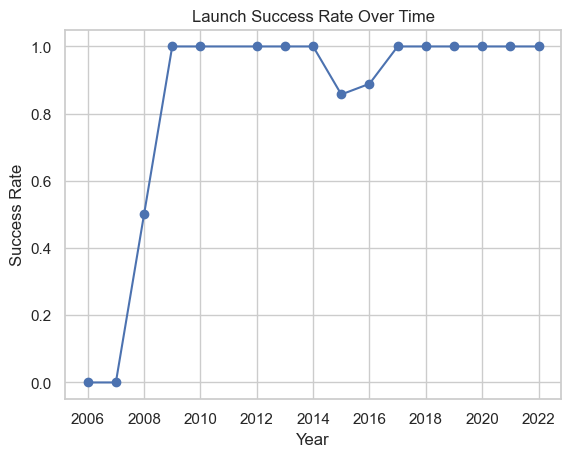

In [13]:
success_rate_by_year = df_clean.groupby('year')['success'].mean()

success_rate_by_year.plot(kind='line', marker='o', title='Launch Success Rate Over Time')
plt.ylabel('Success Rate')
plt.xlabel('Year')
plt.grid(True)
plt.show()

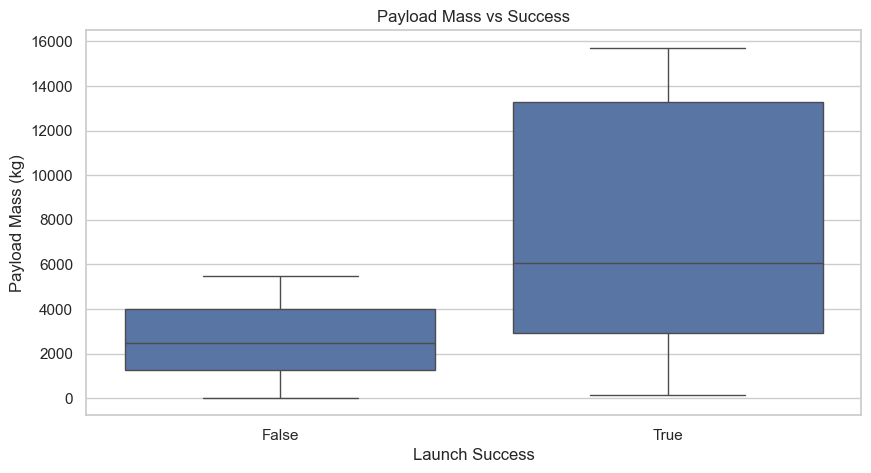

In [14]:
df_clean['payload_mass_kg'] = df_clean['payloads'].apply(extract_payload_mass)
df_payload_mass = df_clean.dropna(subset=['payload_mass_kg'])

plt.figure(figsize=(10, 5))
sns.boxplot(x="success", y="payload_mass_kg", data=df_payload_mass)
plt.title("Payload Mass vs Success")
plt.xlabel("Launch Success")
plt.ylabel("Payload Mass (kg)")
plt.show()

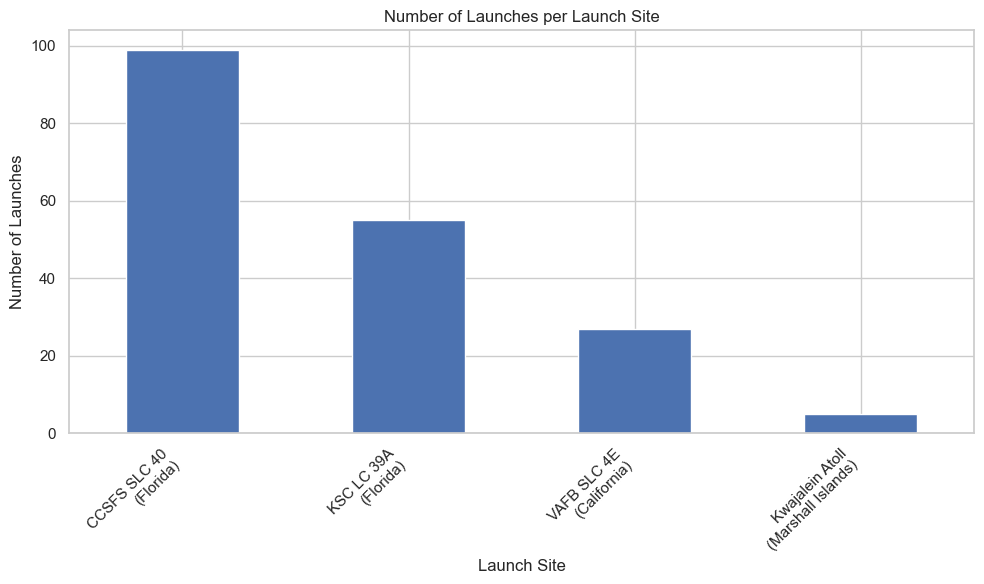

In [ ]:
# Create a new, readable launch site label
df_clean['launch_site'] = df_clean['site_name'] + "\n(" + df_clean['region'] + ")"

site_counts = df_clean['launch_site'].value_counts()

plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar')
plt.title('Number of Launches per Launch Site')
plt.xlabel('Launch Site')
plt.ylabel('Number of Launches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

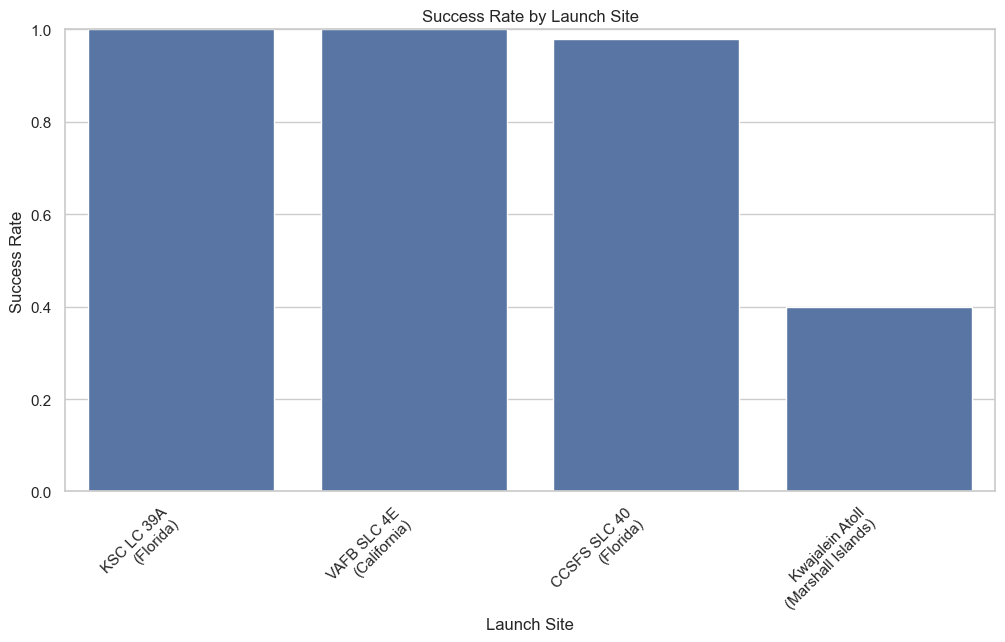

In [19]:
# Calculate success rate per launch site
success_rate_by_site = df_clean.groupby('launch_site')['success'].mean().sort_values(ascending=False)

# Plot success rate by launch site
plt.figure(figsize=(12,6))
sns.barplot(x=success_rate_by_site.index, y=success_rate_by_site.values)
plt.xticks(rotation=45, ha='right')
plt.title("Success Rate by Launch Site")
plt.xlabel("Launch Site")
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.show()

---

## Conclusions

- **Success Rates Over Time:**  
  SpaceX shows a clear trajectory of improving reliability, with early years (2006–2008) showing some failures, and a strong streak of near-perfect success from 2009 onwards.

- **Hypothesis Testing:**  
  Neither payload type nor orbit category significantly affects launch success, suggesting SpaceX’s launch outcomes are consistent across different mission profiles.

- **Payload Mass:**  
  Payload mass does not show a clear correlation with success, further indicating robustness in launch performance.

- **Launch Sites:**  
  Launches are distributed across four distinct sites. Notably, the Kwajalein Atoll site has a lower success rate (40%), likely due to its usage primarily during SpaceX’s early testing years. The other sites demonstrate consistently high success rates, reflecting improvements in launch reliability over time.

- **Limitations:**  
  Some data gaps and NaN values required careful cleaning. The analysis is based on publicly available data, which might not capture all mission complexities.